# Predicting NBA All-Star Appearances with Player Measurements

Scouts have mentioned taking a closer look at player wingspan when drafting prospects. Kevin Durant admitted his long wingspan helped him on defense. Draymond Green and Rudy Gobert admitted their long wingspan helped them stay in the league for their excellent defense. The Milwaukee Bucks used wingspan to draft Thon Maker, but traded him in 2019 as Maker couldn't break out into a defensive stud. But this raises an interesting question: can wingspan predict All-Star appearances? 

Data was extracted using the NBA_Measurements_Value_Scraper. Both Selenium and Beautiful Soup were used to extract data, with multhreading used to speed up the process. The values are stored in a csv file called NBA_Measurements_Value_Added.csv. For this analysis, we'll read from this file.

## Data Extraction and Cleaning

In [2]:
import pandas as pd
import numpy as np

In [3]:
NBA_MVA_df = pd.read_csv("NBA_Measurements_Value_Added.csv").dropna()
NBA_MVA_df = NBA_MVA_df.drop(['Unnamed: 0'], axis=1)
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WINGSPAN > 50]
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WEIGHT != '-']
NBA_MVA_df['WEIGHT'] = pd.to_numeric(NBA_MVA_df['WEIGHT'] , downcast='float')
NBA_MVA_df = NBA_MVA_df[NBA_MVA_df.WEIGHT > 0]

NBA_MVA_df['STANDING REACH'] = pd.to_numeric(NBA_MVA_df['STANDING REACH'] , downcast='float')
NBA_MVA_df['HEIGHT'] = pd.to_numeric(NBA_MVA_df['HEIGHT'] , downcast='float')
NBA_MVA_df['VA'] = pd.to_numeric(NBA_MVA_df['VA'] , downcast='float')
NBA_MVA_df['WINGSPAN'] = pd.to_numeric(NBA_MVA_df['WINGSPAN'] , downcast='float')


NBA_MVA_df= NBA_MVA_df.reset_index()
NBA_MVA_df = NBA_MVA_df.drop(['index'], axis=1)

In [4]:
NBA_MVA_df.head(15)

,PLAYER,VA,ALL-STAR,BODY FAT,HEIGHT,STANDING REACH,WEIGHT,WINGSPAN
0,James Harden,675.200012,1,10.10%,76.00,103.50,222.000000,82.75
1,Anthony Davis,508.500000,1,7.90%,81.25,108.00,221.800003,89.50
2,Nikola Vucevic,493.100006,1,6.10%,82.25,112.50,259.799988,88.50
3,Kevin Durant,485.100006,1,6.60%,81.00,110.00,215.000000,88.75
4,Paul George,479.600006,1,5.00%,79.75,107.00,214.399994,83.25
5,Damian Lillard,449.200012,1,5.90%,73.75,95.50,188.800003,79.75
6,Rudy Gobert,435.299988,0,4.40%,84.50,115.00,237.600006,92.50
7,LeBron James,409.299988,1,6.70%,79.25,106.25,245.000000,84.25
8,LaMarcus Aldridge,402.399994,1,8.70%,82.00,110.00,234.000000,88.75
9,Kawhi Leonard,401.200012,1,5.40%,78.00,106.00,227.399994,87.00


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

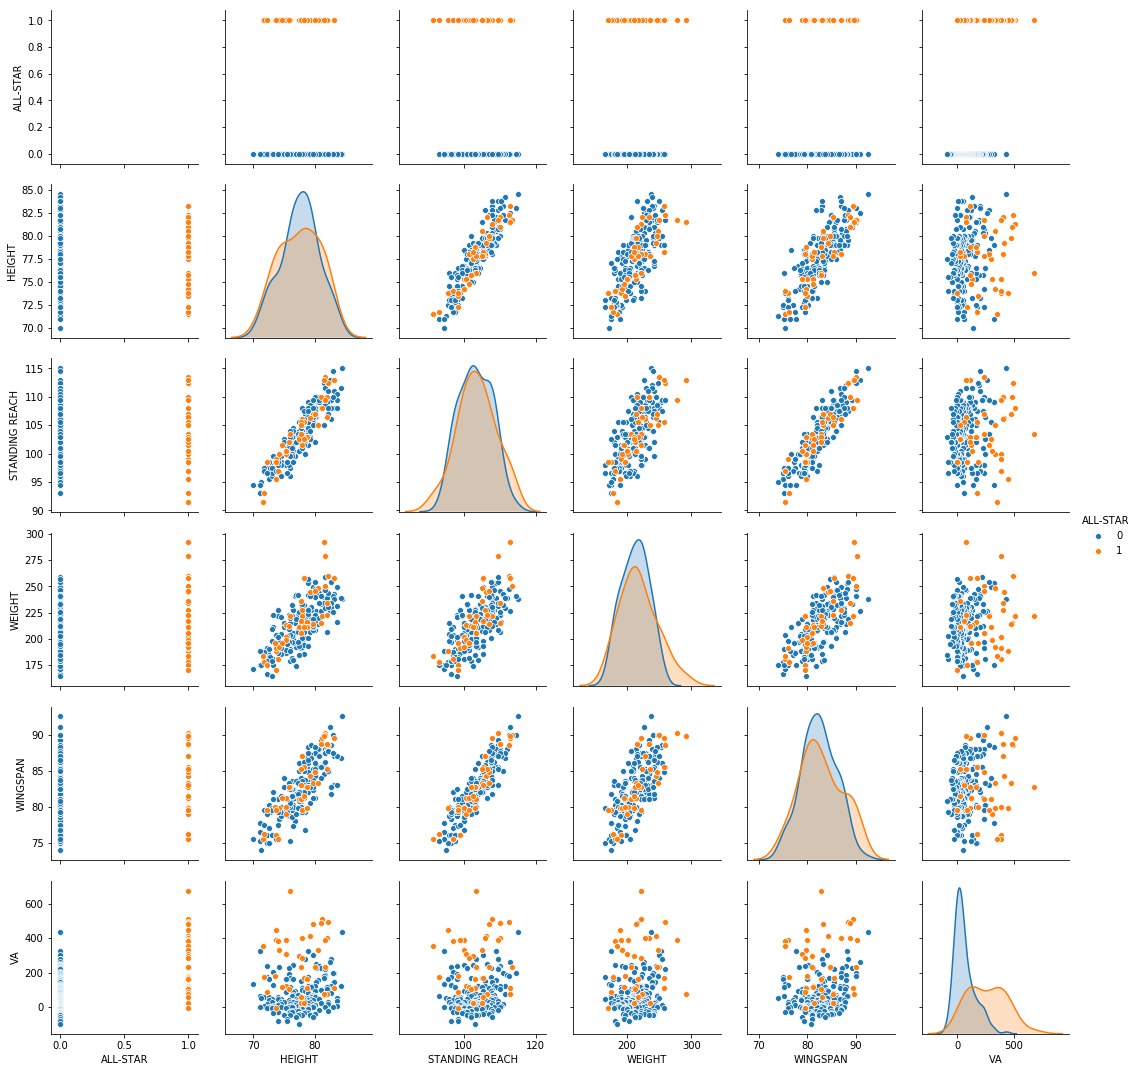

In [7]:
sns.pairplot(NBA_MVA_df[['ALL-STAR', 'HEIGHT', 'STANDING REACH', 'WEIGHT', 'WINGSPAN', 'VA']], hue="ALL-STAR")

If we look at the KDE plots for Height, Standing Reach, Weight, and Wing Span, All-Stars and non All-Stars share very similar statistics. As expected, All-Stars produce more value on the court than non All-Stars. 

If we want to use a classification algorithm to predict whether a player is All-Star worthy, we need to select data points that can easily distinguish between the two. Height, Standing reach, Weight, and Wingspan show a huge categorization when each plotted against value added. But if we took Standing reach and Wingspan, it's difficult to predict which data point would be an all star or not. 

The best outcome is to use PCA to combine the 4 measurement statistics: Height, Standing reach, Weight, and Wingspan. We then plot that PCA value with VA. From there, we'll use Naive Bayes to predict whether a player deserves to be an all star based on the data points provided.

## PCA

In [8]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = NBA_MVA_df.loc[:, ['HEIGHT', 'STANDING REACH', 'WEIGHT', 'WINGSPAN']].values
X = sc.fit_transform(X)

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
principalComponent = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponent, columns = ['PCA'])
principalDf = pd.concat([principalDf, NBA_MVA_df.loc[:,['VA', 'ALL-STAR']]], axis=1)

In [9]:
principalDf.head(20)

,PCA,VA,ALL-STAR
0,-0.057973,675.200012,1
1,2.192874,508.500000,1
2,3.486156,493.100006,1
3,2.130654,485.100006,1
4,0.842473,479.600006,1
5,-2.380367,449.200012,1
6,4.212133,435.299988,0
7,1.440046,409.299988,1
8,2.679806,402.399994,1
9,1.224920,401.200012,1


## Naive Bayes

In [11]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(principalDf[['PCA', 'VA']], principalDf['ALL-STAR'], test_size = 0.25, random_state = 0)

# Feature Scaling


X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [13]:
cm

array([[42,  1],
       [ 7,  6]])

Our confusion matrix shows 1 false positive and 7 false negatives. Which is very good for our test set. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


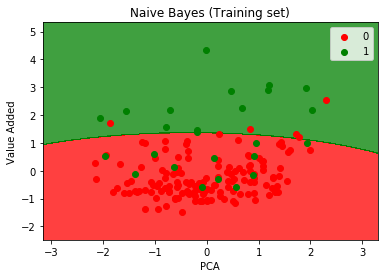

In [14]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Naive Bayes (Training set)')
plt.xlabel('PCA')
plt.ylabel('Value Added')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


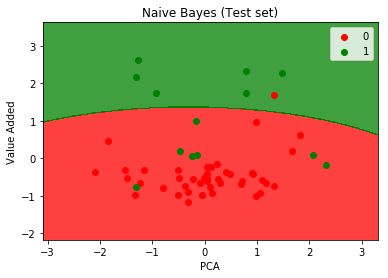

In [15]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Naive Bayes (Test set)')
plt.xlabel('PCA')
plt.ylabel('Value Added')
plt.legend()
plt.show()

## Conclusion

We have created a classification model that predicts All-Star selection based on Values Added and particular Player Measurements. This debunks the theory that wingspan is needed to become an All-Star. All that matters is value added on the court, which is measured by a lot of different factors. 

Notice we do have a lot of false negatives. This is expected, as we took in all All-Star selections in NBA History. So players like Kyle Korver or Jeff Teague are playing average or below right now. But they made the All-Stars in 2015, so that was included in this data set. This data was included because we want to take into account all players' wingspans and measurements in the all-star selection. 